# Exercise 2
## 1 - Logistic Regression

### Visualizing the data

In [228]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_csv('ex2data1.txt', names=['exam1', 'exam2', 'admitted'])
dataset.head()

,exam1,exam2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


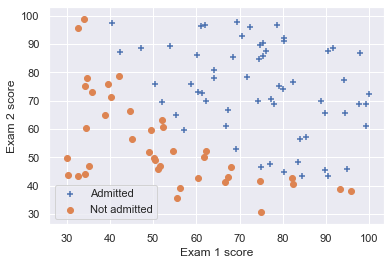

In [229]:
X = dataset.iloc[:,0:2]
y = dataset.iloc[:,2]

pos = y==1
neg = y==0
sns.set()
plt.scatter(X[pos]['exam1'], X[pos]['exam2'], marker='+')
plt.scatter(X[neg]['exam1'], X[neg]['exam2'])
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend(['Admitted', 'Not admitted'])
plt.show()

### Initializing parameters

In [230]:
m, n = X.shape
ones = np.ones((m,1))

X_scaled = (X - np.mean(X))/np.std(X)

X = np.hstack((ones, X)) # (X, y)) will be used for optimization using scipy.optimize's fmin_tnc
theta = np.zeros((n+1,1))
y = y[:,np.newaxis]

# for optimization using gradientDescent, we should use scaled X
# stacking with ones to add the intercept term
X_scaled = np.hstack((ones, X_scaled)) # (X_scaled, y) will be used for optimization gradientDescent

### Checking the dimension
Always check the dimension! Make sure of what you put as argument to your function

In [231]:
print(X[:7])
print(X_scaled[:7])
print(f'X shape: {X.shape}')
print(f'X_scaled shape: {X_scaled.shape}')
print(f'y shape: {y.shape}')
print(f'theta shape: {theta.shape}')

[[ 1.         34.62365962 78.02469282]
 [ 1.         30.28671077 43.89499752]
 [ 1.         35.84740877 72.90219803]
 [ 1.         60.18259939 86.3085521 ]
 [ 1.         79.03273605 75.34437644]
 [ 1.         45.08327748 56.31637178]
 [ 1.         61.10666454 96.51142588]]
[[ 1.         -1.60224763  0.63834112]
 [ 1.         -1.82625564 -1.2075414 ]
 [ 1.         -1.53903969  0.3612943 ]
 [ 1.         -0.28210129  1.0863683 ]
 [ 1.          0.69152826  0.49337794]
 [ 1.         -1.06199728 -0.5357394 ]
 [ 1.         -0.23437234  1.63818413]]
X shape: (100, 3)
X_scaled shape: (100, 3)
y shape: (100, 1)
theta shape: (3, 1)


### Making the function

In [232]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [233]:
def costFunction(theta, X, y):
    m = len(y)
    z = np.dot(X, theta)
    h = sigmoid(z)
    term1 = -y*np.log(h)
    term2 = (1-y)*np.log(1-h)
    cost = np.sum(term1 - term2)/m
    return cost

In [234]:
def grad(theta, X, y):
    m = len(y)
    h = sigmoid(np.dot(X, theta))
    grad = np.dot(X.T, h-y)/m
    return grad

In [235]:
theta.shape

(3, 1)

### Computing the cost

In [236]:
J1 = costFunction(theta, X, y)
J2 = costFunction(theta, X_scaled, y)
print(J1)
print(J2)

0.6931471805599453
0.6931471805599453


### Learning parameters using gradientDescent

In [237]:
def gradientDescent(X, y, theta_initial, alpha, iterations):
    m = len(y)
    theta = theta_initial.copy()
    J_val = []
    for i in range(iterations):
        grad2 = grad(theta,X,y)
        cost = costFunction(theta,X,y)
        theta -= alpha*grad2
        J_val.append(cost)
    return theta, J_val

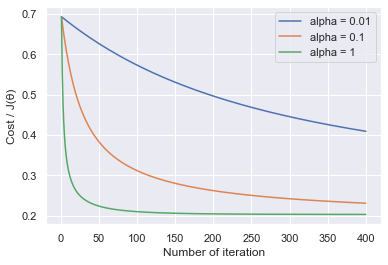

Optimized theta from gradient descent:
 [[1.65947664]
 [3.8670477 ]
 [3.60347302]]


In [238]:
iterations = 400
alpha = [0.01, 0.1, 1]
theta_optimized1 = 0
for i in alpha:
    theta_optimized1, J_value =  gradientDescent(X_scaled, y, theta, alpha=i, iterations=iterations)
    plt.plot(np.arange(1,iterations+1), J_value, label='alpha = '+str(i))
plt.xlabel('Number of iteration')
plt.ylabel('Cost / J(θ)')
plt.legend()
plt.show()

print(f'Optimized theta from gradient descent:\n {theta_optimized1}')

In [239]:
# from the figure above, we get optimized theta stored in variable theta1 at alpha = 1
J1_optimized = costFunction(theta_optimized1, X_scaled, y)
print(J1_optimized)


0.203599187610425


### Learning parameters using scipy.optimize module
The `minimize` function serves for local multivariate optimization. For unconstrained minimization of a function we will use `minimize` function with `Newton-CG` method (passed as an argument). The same function available as `fmin_ncg` in the module, although it is not recommended for use in new scripts, thus I will use the `minimize` function.

The same set of extra arguments should be passed to the f and fprime. Thus, when you define the function for `costFunction` and `grad`, the first argument should be the argument you give initial guess (`theta`). `fmin_ncg` receives array (not vector), so we use the `flatten()` to change the shape. Again, always check the shape of the arguments you pass to the function!

In [240]:
from scipy.optimize import minimize

minimizef = minimize(fun=costFunction, x0=theta.flatten(), jac=grad, args=(X, y.flatten()), method='Newton-CG')
theta_optimized2 = minimizef.x.reshape(3,1)
print(minimizef)
print(theta_optimized2)

     fun: 0.20349770159679256
     jac: array([2.26714716e-05, 1.27288942e-03, 1.55172484e-03])
 message: 'Optimization terminated successfully.'
    nfev: 73
    nhev: 0
     nit: 28
    njev: 187
  status: 0
 success: True
       x: array([-25.16155593,   0.20623349,   0.2014734 ])
[[-25.16155593]
 [  0.20623349]
 [  0.2014734 ]]


Here, I want to check that `fmin_ncg` will give the same optimized theta as the `minimize` function with `Newton-CG` method

In [241]:
from scipy.optimize import fmin_ncg

theta_optimized3 = fmin_ncg(f = costFunction, 
                    x0 = theta.flatten(),fprime = grad, 
                    args = (X, y.flatten()))
print(f'Optimized theta from fmin: {theta_optimized3}')


Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 28
         Function evaluations: 73
         Gradient evaluations: 187
         Hessian evaluations: 0
Optimized theta from fmin: [-25.16155593   0.20623349   0.2014734 ]


In [242]:
J2_optimized = costFunction(theta_optimized2, X, y)
print(J2_optimized)

0.20349770159679256


Plot with the best fit line obtained through scipy `minimize`

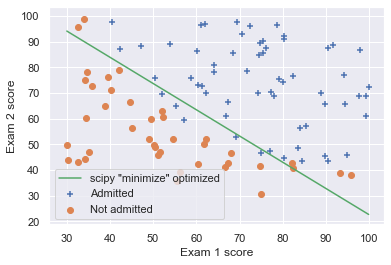

In [243]:
# plot with the best fit line

pos = y[:,0] ==1
neg = y[:,0] ==0
sns.set()
plt.scatter(X[:,1][pos], X[:,2][pos], marker='+', label='Admitted')
plt.scatter(X[:,1][neg], X[:,2][neg], label='Not admitted')


x2_value= np.array([np.min(X[:,1]),np.max(X[:,1])])
y2_value=-(theta_optimized2[0] + theta_optimized2[1]*x2_value)/theta_optimized2[2]
plt.plot(x2_value,y2_value, 'g', label='scipy "minimize" optimized')

plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend()
plt.show()

Plot with the best fit line obtained through `gradientDescent`. Note that the scale is different from the original.

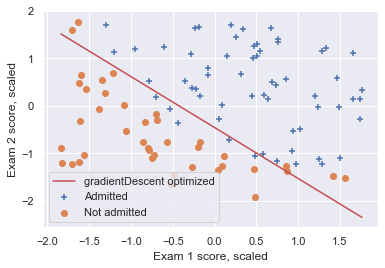

In [244]:
pos = y[:,0] ==1
neg = y[:,0] ==0
sns.set()

plt.scatter(X_scaled[:,1][pos], X_scaled[:,2][pos], marker='+', label='Admitted')
plt.scatter(X_scaled[:,1][neg], X_scaled[:,2][neg], label='Not admitted')

x_value= np.array([np.min(X_scaled[:,1]),np.max(X_scaled[:,1])])
y_value=-(theta_optimized1[0] + theta_optimized1[1]*x_value)/(theta_optimized1[2])
plt.plot(x_value,y_value, "r", label='gradientDescent optimized')

plt.xlabel('Exam 1 score, scaled')
plt.ylabel('Exam 2 score, scaled')
plt.legend(loc=0)
plt.show()

### Evaluating logistic regression

In [245]:
pred1 = [sigmoid(np.dot(X_scaled, theta_optimized1.flatten())) >= 0.5]
print(f'Train accuracy using gradientDescent: {np.mean(pred1 == y.flatten()) * 100:.4f}%')
pred2 = [sigmoid(np.dot(X, theta_optimized2.flatten())) >= 0.5]
print(f'Train accuracy using minimize: {np.mean(pred2 == y.flatten()) * 100:.4f}%')

Train accuracy using gradientDescent: 89.0000%
Train accuracy using minimize: 89.0000%


In [246]:
examsval = [[45, 85]]
m = len(examsval)
ones = np.ones((m,1))
x = np.array(examsval)
x = np.hstack((ones, x)).reshape(m,3)
pred = sigmoid(np.dot(x, theta_optimized2))
print(pred)

[[0.77629253]]
